In [31]:
import os
import numpy as np
import string
import pandas as pd
import tarfile
from joblib import dump
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn import model_selection
import nltk
from nltk.corpus import stopwords


# **Data Preprocessing**

In [32]:
tar = tarfile.open("20_newsgroups.tar")
tar.extractall()
tar.close()

In [33]:
f_paths=[]
i=-1
path="20_newsgroups"
folderlist=os.listdir(path)
if ".DS_Store" in folderlist:
  folderlist.remove('.DS_Store')
for folder in folderlist:
  i+=1
  filelist=os.listdir(path+'/'+folder)
  for file in filelist:
    f_paths.append((path+'/'+folder+'/'+file,i))
len(f_paths)


np.save('target_names.npy', folderlist)

In [34]:
x_train,x_test=model_selection.train_test_split(f_paths)
len(x_train),len(x_test)

(14997, 5000)

In [35]:
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(len(x_train)):
  X_train.append(x_train[i][0])
  Y_train.append(x_train[i][1])
for i in range(len(x_test)):
  X_test.append(x_test[i][0])
  Y_test.append(x_test[i][1])
Y_train=(np.array([Y_train])).reshape(-1)
Y_test=(np.array([Y_test])).reshape(-1)
Y_train.shape,Y_test.shape

((14997,), (5000,))

In [36]:
nltk.download('stopwords')
stop=set(stopwords.words("english"))
stop_words=list(stop)+list(set(string.punctuation))
len(stop_words)

[nltk_data] Downloading package stopwords to /Users/redap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


211

In [37]:
vocab={}
count =0
for filename in X_train:
  count+=1
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  for word in words:
    if len(word)>2:
      if word.lower() not in stop_words:
        if word.lower() in vocab:
          vocab[word.lower()]+=1
        else:
          vocab[word.lower()]=1
  f.close()

In [38]:
len(vocab)

353716

In [39]:
sorted_vocab = sorted(vocab.items(), key= operator.itemgetter(1), reverse= True) 

In [40]:
feature_names = []
for i in range(len(sorted_vocab)):
    if(sorted_vocab[2000][1] <= sorted_vocab[i][1]):
        feature_names.append(sorted_vocab[i][0])


feature_names_df = pd.DataFrame(feature_names, columns=['word'])
feature_names_df.to_csv('feature_names.csv', index=False)
print(len(feature_names))

2002


In [41]:

df_train=pd.DataFrame(columns=feature_names)
df_test=pd.DataFrame(columns=feature_names)

In [42]:
count_train,count_test=0,0


for filename in X_train:
  count_train+=1
  df_train.loc[len(df_train)]=np.zeros(len(feature_names))
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  for word in words:
    if word.lower() in df_train.columns:
      df_train[word.lower()][len(df_train)-1]+=1 
  f.close()
  
for filename in X_test:
  count_test+=1

  df_test.loc[len(df_test)]=np.zeros(len(feature_names))
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()

  for word in words:
    if word.lower() in df_test.columns:
      df_test[word.lower()][len(df_test)-1]+=1 
  f.close()
  

print(count_train,count_test)

14997 5000


In [43]:
X_train=df_train.values
X_test=df_test.values

# **Model Development**

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       270
           1       0.81      0.92      0.86       259
           2       0.83      0.89      0.86       256
           3       0.75      0.78      0.77       237
           4       0.93      0.94      0.93       252
           5       0.88      0.79      0.83       255
           6       0.98      0.96      0.97       255
           7       0.96      0.90      0.93       243
           8       0.91      0.85      0.88       227
           9       0.68      0.54      0.60       240
          10       0.82      0.95      0.88       240
          11       0.87      0.86      0.87       244
          12       0.82      0.78      0.80       259
          13       0.86      0.78      0.82       268
          14       0.81      0.84      0.82       264
          15       0.75      0.87      0.80       273
          16       0.91      0.87      0.89       239
          17       0.96    

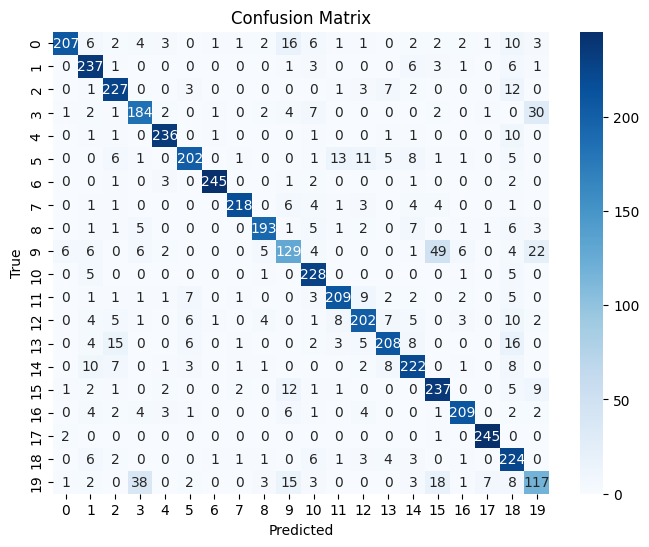

/var/folders/4p/rtgp5bx13zx1hbrdf47k7wjh0000gn/T/ipykernel_54873/2631329958.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Y_test, palette='Set3')


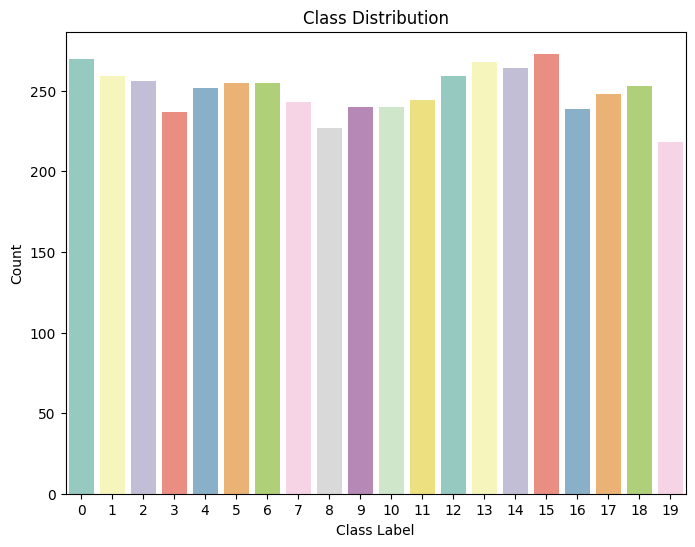

Testing:  0.8358


In [44]:
clf=MultinomialNB()
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)




conf_matrix = confusion_matrix(Y_test, Y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(8, 6))
sns.countplot(x=Y_test, palette='Set3')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

print(classification_report(Y_test,Y_pred))
print("R^2 Test: ",clf.score(X_test,Y_test))

# **Save Model**

In [45]:

model_dir = '/Users/redap/Documents/GitHub/CS481' 
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'multinomial_nb_model.joblib')
dump(clf, model_path)


['/Users/redap/Documents/GitHub/CS481/multinomial_nb_model.joblib']